No best model found


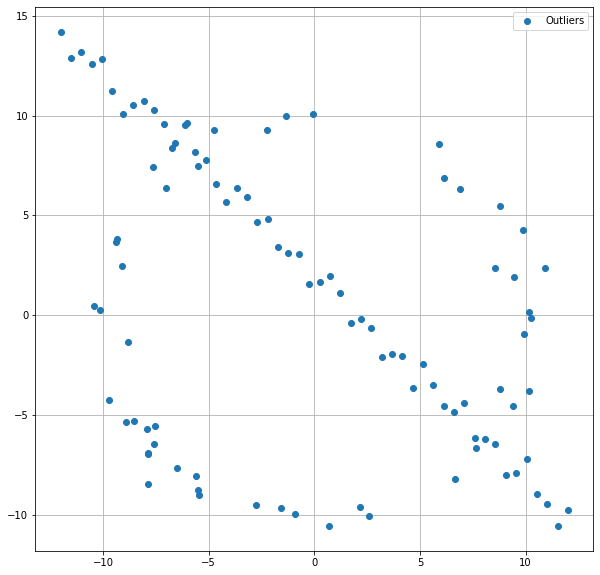

In [4]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def getRandomPoints(data, n):
    #return n random points from data
    count = 0
    sample = []

    while count < n:
        index = np.random.randint(len(data))
        x = data[index][0]
        y = data[index][1]

        if (x, y) not in sample:
            sample.append((x, y))
            count += 1

    return sample


def getCircleParams(sample):
    #return circle parameters from sample
    pt1 = sample[0]
    pt2 = sample[1]
    pt3 = sample[2]

    A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]]) 
    B = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])		
    inv_A = inv(A)

    a, b = np.dot(inv_A, B) / 2
    a, b = a[0], b[0]
    r = np.sqrt((a - pt1[0])**2 + (b - pt1[1])**2)

    return (a, b, r)

def getInliersAndDistance(circle, data, threshold):
    x_data = data[:, 0]
    y_data = data[:, 1]

    a = circle[0]
    b = circle[1]
    r = circle[2]

    total_distance = 0
    inliers = []
    for i in range(len(x_data)):
        distance = np.sqrt((x_data[i] - a)**2 + (y_data[i] - b)**2)

        if abs(distance - r) <= threshold:
            inliers.append([x_data[i], y_data[i]])
            total_distance += abs(distance - r)
    
    return inliers, total_distance
N = 100
half_n = N//2

R = 10
s = R/16
t = np.random.uniform(0, 2*np.pi ,half_n)
n = s*np.random.randn(half_n)

x ,y = (R + n)*np.cos(t), (R + n)*np.sin(t)

X_circ = np.hstack((x.reshape(half_n , 1), y.reshape(half_n, 1)))

m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(X[:,0], X[:, 1], 'o', label='Outliers')
ax.grid(True)

#initializing variables
x_data = X[:, 0]
y_data = X[:, 1]
iterations = 35
inlier_threshold = R/8
inlier_count_threshold = 50
best_model = [0, 0, 999999, []]
for i in range(iterations):
    # get three points from data
    sample = getRandomPoints(X, 3)

    initial_circle = getCircleParams(sample)

    if abs(R - initial_circle[2]) > 1.5*R:
        continue
 
    inliers, toal_distance = getInliersAndDistance(initial_circle, X, inlier_threshold)

    if len(inliers) < inlier_count_threshold:
        continue

    inlier_sample = getRandomPoints(inliers, 3)

    circle = getCircleParams(inlier_sample)

    inliers, toal_distance = getInliersAndDistance(circle, X, inlier_threshold)
    if len(inliers) < inlier_count_threshold:
        continue
    if len(best_model[-1]) < len(inliers):
        best_model = [circle, initial_circle, sample, toal_distance, inliers]
    elif len(best_model[-1]) == len(inliers):
        if best_model[3] > toal_distance:
            best_model = [circle, initial_circle, sample, toal_distance, inliers]

if len(best_model[-1]) == 0:
    print("No best model found")

else:
    inliers = np.array(best_model[-1])
    ax.plot(inliers[:, 0], inliers[:, 1], 'o', label='Inliers')

    best_samples = np.array(best_model[2])
    ax.plot(best_samples[:,0], best_samples[:, 1], 'o', label='Best samples')

    a, b, r = best_model[0][0], best_model[0][1], best_model[0][2]
    circle = Circle((a, b), radius=r, color='r', fc='y', fill=False, label='RANSAC')
    ax.add_patch(circle)

    a, b, r = best_model[1][0], best_model[1][1], best_model[1][2]
    init_circle = Circle((a, b), radius=r, color='b', fc='y', fill=False, label='Best sample circle')
    ax.add_patch(init_circle)

ax.legend();

In [89]:
import numpy as np
import cv2 as cv
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
import random

def data_pts(): 
    N = 100
    half_n = N// 2
    r = 10
    s = r /16
    t = np.random.uniform (0 , 2*np.pi , half_n )
    n = s * np.random.randn( half_n )
    x , y = (r + n)*np.cos(t) , (r + n)*np.sin(t)
    X_circ = np.hstack(( x.reshape(half_n , 1 ) , y.reshape (half_n , 1 )))
    m, b = -1, 2
    x = np.linspace (-12, 12 , half_n )
    y = m*x + b + s*np.random.randn( half_n )
    X_line = np.hstack(( x.reshape ( half_n , 1 ) , y.reshape ( half_n , 1 ) ) )
    X = np.vstack ( ( X_line ,X_circ  ) )
    return X

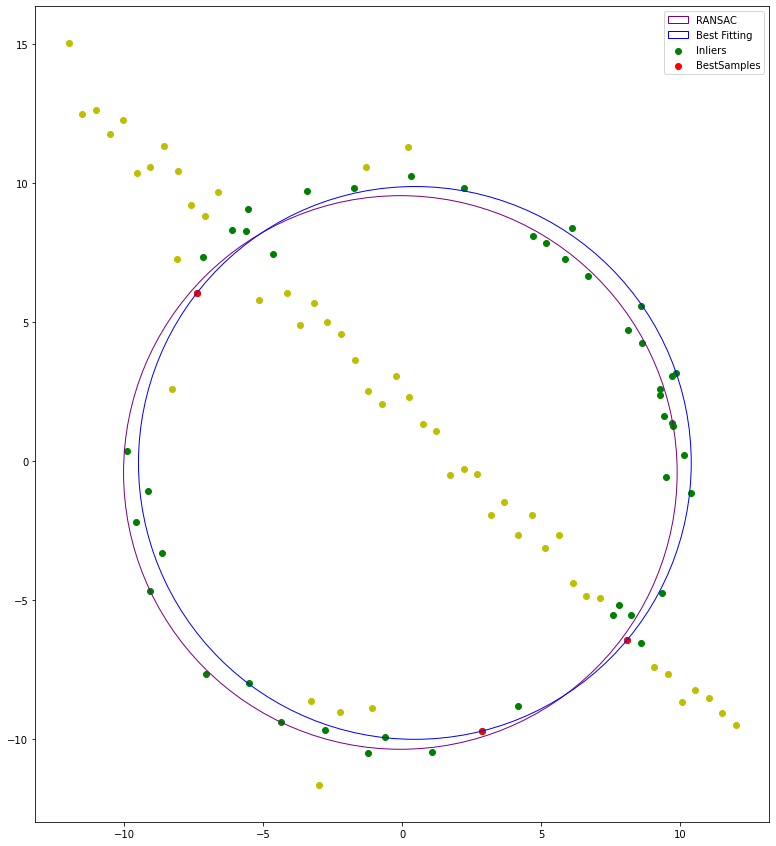

In [93]:
def Circle_func(pts ,N ,t):
    max_in_ct = 0
    for s in range(0 , N+1):
        d1 , d2 , d3 = random.randint(0,len(pts)-1), random.randint(0,len(pts)-1) , random.randint(0,len(pts)-1)
        x1,x2,x3 = pts[d1][0] , pts[d2][0] , pts[d3][0]
        y1,y2,y3 = pts[d1][1] , pts[d2][1] , pts[d3][1]

        P = np.array([[2*x1 , 2*y1 , 1] , [2*x2 , 2*y2 , 1] , [2*x3 , 2*y3 , 1]])
        if (np.linalg.det(P)==0): continue
        K = np.array([[x1**2 +y1**2] , [x2**2 +y2**2] , [x3**2 +y3**2]])*(-1)
        a = np.linalg.inv(P) @ K
        g , f , c = a[0][0] , a[1][0] , a[2][0]
        rad = np.sqrt(g**2 + f**2 -c)
        if (rad>10): continue
        cen = [-g , -f]

        in_ct = 0
        for  i in range(0 , len(pts)):
            d = abs(np.sqrt((pts[i][0]-cen[0])**2 + (pts[i][1]-cen[1])**2) - rad)
            if d < t:
                in_ct += 1
        if in_ct > max_in_ct:
            max_in_ct = in_ct
            cof =  [f, g, c]
            b_pts = np.array([pts[d1],pts[d2],pts[d3]])
    
    return (cof,b_pts)

M = data_pts()
n = int (np.log(0.01) / np.log(1 - (0.5)**3)) 
ran , ransac_sam  = Circle_func(M,n,1)
cy, cx ,C = ran[0] , ran[1] , ran[2]
R = np.sqrt(cx**2 + cy**2 -C)

IN,Out = [] ,[]
for pt in X:
    d = abs(np.sqrt((pt[0]+cx)**2 + (pt[1]+cy)**2) - R)
    if d < t:
        IN.append(pt)
    else:
        Out.append(pt)

Inarr = np.array(IN).T
Outarr = np.array(Out).T
Sam = ransac_sam.T

best , b_pts = Circle_func(IN,10000,1)
b_cy, b_cx ,b_C = best[0] , best[1] , best[2]
b_R = np.sqrt(b_cx**2 + b_cy**2 -b_C)
b_sam = b_pts.T

figure, ax = plt.subplots( 1, figsize=(15,15) )
ax.scatter(Inarr[0],Inarr[1], color="g" , label="Inliers")
ax.scatter(Outarr[0],Outarr[1],color="y")
ax.scatter(b_sam[0] ,b_sam[1], color="r" , label="BestSamples")
ax.plot(-cx,-cy,color="purple")
ax.plot(-b_cx,-b_cy,color="b")
ax.set_aspect( 1 )
ransac = plt.Circle((-cx,-cy), R, fill=False, color="purple" ,label="RANSAC")
plt.gca().add_patch(ransac)
best_fitting = plt.Circle((-b_cx,-b_cy), b_R, fill=False, color="b" ,label="Best Fitting")
plt.gca().add_patch(best_fitting)
plt.legend(loc ="upper right")
plt.show()